In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pointpats

/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packa

In [3]:
import libpysal

In [4]:
path = libpysal.examples.get_path('burkitt.shp')

In [5]:
from pointpats import SpaceTimeEvents, knox

In [6]:
events = SpaceTimeEvents(path, 'T')

/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


In [7]:
events

In [8]:
import numpy

In [9]:
knox?

Signature: knox(s_coords, t_coords, delta, tau, permutations=99, debug=False)
Docstring:
Knox test for spatio-temporal interaction. :cite:`Knox:1964`

Parameters
----------
s_coords        : array
                  (n, 2), spatial coordinates.
t_coords        : array
                  (n, 1), temporal coordinates.
delta           : float
                  threshold for proximity in space.
tau             : float
                  threshold for proximity in time.
permutations    : int, optional
                  the number of permutations used to establish pseudo-
                  significance (the default is 99).
debug           : bool, optional
                  if true, debugging information is printed (the default is
                  False).

Returns
-------
knox_result     : dictionary
                  contains the statistic (stat) for the test and the
                  associated p-value (pvalue).
stat            : float
                  value of the knox test for the dataset.

In [10]:
events.space

array([[300., 302.],
       [291., 270.],
       [326., 263.],
       [299., 376.],
       [267., 327.],
       [266., 356.],
       [267., 345.],
       [262., 338.],
       [268., 335.],
       [335., 275.],
       [302., 272.],
       [301., 304.],
       [302., 272.],
       [324., 337.],
       [260., 338.],
       [306., 385.],
       [284., 362.],
       [293., 332.],
       [274., 353.],
       [263., 333.],
       [307., 386.],
       [274., 357.],
       [297., 282.],
       [288., 365.],
       [283., 366.],
       [290., 352.],
       [284., 341.],
       [286., 341.],
       [282., 350.],
       [292., 278.],
       [305., 381.],
       [298., 378.],
       [299., 381.],
       [287., 342.],
       [276., 380.],
       [261., 345.],
       [273., 347.],
       [284., 357.],
       [266., 361.],
       [285., 360.],
       [278., 350.],
       [305., 321.],
       [293., 332.],
       [297., 375.],
       [332., 273.],
       [256., 345.],
       [275., 357.],
       [267.,

In [11]:
events.time

array([[4.130e+02, 1.000e+00],
       [4.720e+02, 1.000e+00],
       [5.110e+02, 1.000e+00],
       [6.890e+02, 1.000e+00],
       [7.300e+02, 1.000e+00],
       [8.470e+02, 1.000e+00],
       [8.710e+02, 1.000e+00],
       [8.990e+02, 1.000e+00],
       [9.210e+02, 1.000e+00],
       [1.134e+03, 1.000e+00],
       [1.190e+03, 1.000e+00],
       [1.214e+03, 1.000e+00],
       [1.224e+03, 1.000e+00],
       [1.322e+03, 1.000e+00],
       [1.399e+03, 1.000e+00],
       [1.480e+03, 1.000e+00],
       [1.503e+03, 1.000e+00],
       [1.549e+03, 1.000e+00],
       [1.567e+03, 1.000e+00],
       [1.607e+03, 1.000e+00],
       [1.615e+03, 1.000e+00],
       [1.657e+03, 1.000e+00],
       [1.688e+03, 1.000e+00],
       [1.695e+03, 1.000e+00],
       [1.714e+03, 1.000e+00],
       [1.811e+03, 1.000e+00],
       [1.813e+03, 1.000e+00],
       [1.910e+03, 1.000e+00],
       [1.986e+03, 1.000e+00],
       [1.996e+03, 1.000e+00],
       [2.049e+03, 1.000e+00],
       [2.053e+03, 1.000e+00],
       [

In [12]:
numpy.random.seed(100)

In [13]:
result = knox(events.space, events.t, delta=20, tau=5, permutations=99)

In [14]:
result

{'stat': 13, 'pvalue': array([0.17])}

In [15]:
events.space.shape

(188, 2)

In [16]:
events.t.shape

(188, 1)

## New Implementation

- Analytical Inference
- Local Knox
- Better Reporting

In [17]:
path

'/home/serge/mambaforge/envs/pointpats/lib/python3.11/site-packages/libpysal/examples/burkitt/burkitt.shp'

In [18]:
import geopandas

In [19]:
df = geopandas.read_file(path)

In [20]:
df.head()

,ID,X,Y,T,AGE,DATE,geometry
0,1.0,300.0,302.0,413.0,22.0,1901-02-16,POINT (300.000 302.000)
1,2.0,291.0,270.0,472.0,5.0,1901-04-16,POINT (291.000 270.000)
2,3.0,326.0,263.0,511.0,12.0,1901-05-25,POINT (326.000 263.000)
3,4.0,299.0,376.0,689.0,6.0,1901-11-19,POINT (299.000 376.000)
4,5.0,267.0,327.0,730.0,4.0,1901-12-30,POINT (267.000 327.000)


<Axes: >

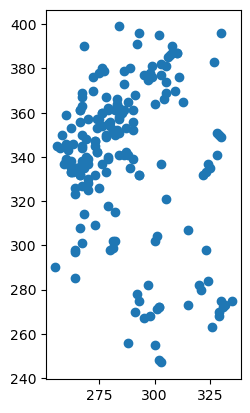

In [21]:
df.plot()

In [22]:
from scipy.spatial import KDTree

In [23]:
stree = KDTree(df[['X', 'Y']])

In [24]:
ttree = KDTree(df[['T']])

In [25]:
delta = 20
tau = 5

In [26]:
sneighbors = stree.query_ball_tree(stree, r=delta)
sneighbors = [set(neighbors).difference([i]) for i,neighbors in enumerate(sneighbors)]

In [27]:
tneighbors = ttree.query_ball_tree(ttree, r=tau)
tneighbors = [set(neighbors).difference([i]) for i,neighbors in enumerate(tneighbors)]

In [28]:
sneighbors[0]

{11, 41, 68, 70, 73, 107}

In [29]:
tneighbors[0]

set()

In [30]:
ns = numpy.array([len(neighbors) for neighbors in sneighbors])

In [31]:
ns

array([ 6, 10,  9, 31, 45, 61, 69, 52, 53,  9, 10,  4, 10,  7, 49, 22, 54,
       16, 75, 48, 21, 66,  8, 53, 54, 50, 53, 50, 63,  8, 26, 30, 27, 46,
       26, 56, 85, 57, 53, 55, 74,  6, 16, 35, 10, 42, 67, 70, 11, 33,  8,
       74, 64, 69, 56,  4, 52, 61, 55, 18,  9, 10, 15, 65, 11, 58, 11, 22,
        4,  7, 13, 75,  7, 12,  1,  7, 34, 27,  4, 46,  7,  7, 58, 20, 10,
       85, 10, 56, 64,  7, 39,  3, 13, 39, 57, 29, 25, 22, 34, 21,  8, 10,
       51, 55, 56, 10, 47, 12, 12, 58, 54, 23, 21, 10, 51, 31, 24, 10, 11,
       75, 46, 63, 51, 67, 34, 65,  5, 64, 52, 11, 16, 27,  3, 11, 11, 35,
       50, 48, 75, 49, 49, 34,  4, 53, 17, 46, 69, 49, 59, 59, 54, 26, 41,
       52, 57, 46, 17, 27, 46, 55,  9, 62, 46, 48, 57, 39, 49, 40, 33,  5,
       65, 16, 81, 58, 51, 21, 11, 49, 68, 53, 70, 41,  5, 51, 21, 66, 27,
       48])

In [32]:
nt = numpy.array([len(neighbors) for neighbors in tneighbors])

In [33]:
nt

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 4, 3, 3, 3, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 2,
       1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0])

In [34]:
stneighbors = [sneighbors_i.intersection(tneighbors_i) for sneighbors_i, tneighbors_i in zip(sneighbors, tneighbors)]

In [35]:
nst = numpy.array([len(neighbors) for neighbors in stneighbors])

In [36]:
nst

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
nst.sum()

26

In [38]:
NST = nst.sum() / 2

In [39]:
NT = nt.sum() / 2
NS = ns.sum() / 2

In [40]:
NT

52.0

In [41]:
NS

3429.0

In [42]:
NST


13.0

In [43]:
188*187/2

17578.0

In [44]:
17578 -3429

14149

In [45]:
3429-13

3416

In [46]:
17578-52

17526

In [47]:
52-13

39

In [48]:
14149-39

14110

In [49]:
ENST = NS*NT / 17578

In [50]:
ENST

10.143816133803618

In [51]:
from scipy.stats import poisson

In [52]:
1 - poisson.cdf(13, 10.1438)

0.14624435546482228

## Next Steps

- wrap knox functionality
- generalize away from shapefile
- summary report
- analytical inference
- permutation inference
- local knox

In [53]:
from pointpats.spacetime import _knox

In [54]:
ttree.data.shape

(188, 1)

In [55]:
space =df[['X', 'Y']]
time = df['T'].values
time = time.reshape(-1,1)

In [58]:
_knox(space, time, delta=20, tau=5)

{'ns': 3429.0,
 'nt': 52.0,
 'nst': 13.0,
 'pairs': 17578.0,
 'expected': array([[1.01438161e+01, 3.41885618e+03],
        [4.18561839e+01, 1.41071438e+04]]),
 'observed': array([[1.300e+01, 3.416e+03],
        [3.900e+01, 1.411e+04]]),
 'p_value_poisson': 0.14624558197140414}